# Model Development

__Submission__

There are sections where you have to input your own code. When complete this has to be submitted as part of course completion.

When you have run all the code sections as well as fill in your own code, do the following to save the notebook as a single html file for submission:

`File -> Download as -> HTML`

Ensure that all outputs are displayed on your jupyter notebook before download as html.

__Today's Lesson__

In general, the model development process is as follows:

0. Define task: e.g.: Classification or Regression

1. Preprocess Data

2. Select algorithm to use: e.g. RandomForest

3. Model training: Fit algorithm with data to form model.

4. Evaluate trained model with relevant metrics

5. Re-train model with different set of hyperparameters (Hyperparameter tuning)


As we aim to be low code, and simple but efficient steps 2 to 5 can be simplified using automated model search and tuning tools.
e.g.:

- auto-sklearn
- tpot

Different model search and tuning tools take different approaches on model selection and hyperparamter tuning.

## Some definitions:

__Model Search__

Search for the ML algorithm that maximises a certain metric (e.g.: accuracy). 

__Hyperparameter Tuning__

Tweak the settings of the ML algorithm to maximise a certain metric (e.g.: accuracy). 

Examples of hyperparameters: number of trees, depth, etc

There area a variety of (hyperparameter/model) search methodologies: random search, genetic algorithms, bayesian search.

## TPOT

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. TPOT will automate the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for your data.

![tpot](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-ml-pipeline.png)

Once TPOT is finished searching (or you get tired of waiting), it provides you with the Python code for the best pipeline it found so you can tinker with the pipeline from there.

![tpot2](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-pipeline-example.png)

In [1]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
import os
import numpy as np
from joblib import dump, load

# Data

In this section we would have to do a few data transformations to make the data understandable to algorithms.
In general, non-numbers would have to be converted into some form of numbers.

1. Categorical data -> map each category to a number (Label Encoding) 
![lbl enc](https://miro.medium.com/max/578/1*VinegxkUYMzik9GpucWCFA.png)
2. Categorical data -> one hot encoding

![one hot](https://i.imgur.com/mtimFxh.png)

For numbers already in numerical form, we can scale them or leave them untouch (tpot handles them).


__Load the Dataset__

In [2]:
# Define dataset path
DATASET='../../01_python_for_ds/student_data.parquet'

# Load dataset
df = pd.read_parquet(DATASET)

# REMOVE ID COLUMN and label column
del df['id']

__Numerical and Categorical Columns__

In [3]:
# Columns
categorical_cols = ['school', 'sex', 'address', 'famsize',
                    'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
                    'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                    'higher', 'internet', 'romantic', ]
numeric_cols = [
    'Dalc', 'Fedu', 'Medu', 'Walc', 'absences',
    'age', 'failures', 'famrel', 'freetime', 'goout', 'health',
    'studytime', 'traveltime'
    ]

## Data Processing

Here we'll define our preprocessors and preprocessing pipeline.

We'll be doing columns-wise transformations, so we can deal with numeric and categorical columns differently.

In [ ]:
# Simple filling up of missing values for numeric columns
# TPOT is capable of doing some numerical transformations, so we dont have to do much here.
# We can add StandardScaler if we want to do some numerical transformations.
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
    ])

# Imputer -> One hot encoding
# Imputer to fill in missing values if any
# ONE HOT ENCODING of categorical variables         
categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column wise transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ],
    remainder='passthrough'
)

# Overall preprocessing pipeline
preproc_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor)
    ]
)

#### Split dataset into train and test sets

A better sense of a model's performance can be found using what's known as a holdout set: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance. This splitting can be done using the train_test_split utility in Scikit-Learn:

In [ ]:
# Split dataset into trainset and testset                                                                                                                                                                 
df_train, df_test = train_test_split(
    df,
    train_size = 0.70,
    shuffle=True,
    random_state=24,
    stratify= df['passed'], # balance train/test set with labels                                                                                                                                          

)

print(df_train.shape)
print(df_test.shape)

#### Preprocess Data

In [35]:
# Fit data into preprocessing pipeline for it to 'learn' how to preprocess                                                                                                                                
preproc = preproc_pipeline.fit(df_train)

# Transform data with preprocessing steps                                                                                                                                                                 
df_train = preproc.transform(df_train)
df_test = preproc.transform(df_test)


# Label encoder for train and test targets                                                                                                                                                                
# Fit on train set only                                                                                                                                                                                   
label_encoder = LabelEncoder().fit(df_train[:,-1])

# transform train and test sets                                                                                                                                                                           
df_train_labels = label_encoder.transform(df_train[:,-1])
df_test_labels = label_encoder.transform(df_test[:,-1])

In [36]:
# Remove label column from feature sets                                                                                                                                                                   
df_train = np.delete(df_train, -1, axis=1)
df_test = np.delete(df_test, -1, axis=1)



__Saving the preprocessors__

Save preprocessors so that we can use them during deployment.

Fitting preprocessors will create a map between strings found in features to its numerical form. 

This mapping has to be consistent when running both training and inference. 

So we need to save the mapping created by the transformations in the preprocessing pipeline.   

In [ ]:
# Save preprocessors so we can use them during deployment                                                                                                                                                 
# Fitting preprocessors will create a map between strings found in features to its numerical form.                                                                                                        
# This mapping has to be consistent when running both training and inference.                                                                                                                             
# So we need to save the mapping created by the transformations in the preprocessing pipeline.                                                                                                            
dump(label_encoder, 'label_encoder.joblib')
dump(preproc, 'preproc.joblib')

# Model Search

In [41]:
# Define our TPOT Classifier settings                                                                                                                                                                     
pipeline_optimizer = TPOTClassifier(
    generations=5,
    population_size=50, cv=5,
    warm_start=False,
    scoring='average_precision',
    random_state=42, verbosity=2)


In [42]:
# Train the classifier                                                                                                                                                                                    
print("Training: ")
pipeline_optimizer.fit(df_train.astype(np.float64), df_train_labels.astype(np.uint8))

# Metrics                                                                                                                                                                                                 
print("Test score: ")
print(pipeline_optimizer.score(df_test.astype(np.float64), df_test_labels.astype(np.uint8)))

Training: 


Generation 1 - Current best internal CV score: 0.8576889676755135
Generation 2 - Current best internal CV score: 0.8586884807351115
Generation 3 - Current best internal CV score: 0.8586884807351115
Generation 4 - Current best internal CV score: 0.8670698998017727
Generation 5 - Current best internal CV score: 0.8670698998017727

Best pipeline: RandomForestClassifier(Normalizer(input_matrix, norm=l1), bootstrap=True, criterion=gini, max_features=0.45, min_samples_leaf=17, min_samples_split=2, n_estimators=100)
Test score: 
0.8328639100013879


When satisfied with your model, you can export it to a python script

In [ ]:
# EXPORT                                                                                                                                                                                                  
pipeline_optimizer.export('tpot_exported_pipeline.py')

# Evaluation

There are a few metrics we can use to measure performance of a classification model.

- Confusion Matrix
- Accuracy
- Precision & Recall
- F1 Score



## Confusion Martrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

The Scikit-Learn toolkit provides the function to generate confusion matrix given predicted values and target values.

In [24]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy import interp
import itertools

Function to plot confusion matrix is as follows:

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Run inference to generate predicted values.

Generate confusion matrix using predicted values and original target values (labels)

In [45]:
class_names = ['fail','pass']

y_test = pipeline_optimizer.predict(df_test.astype(np.float64))

cnf_matrix = confusion_matrix( y_test, df_test_labels.astype(np.uint8))
np.set_printoptions(precision=2)


Plot the confusion matrix with matplotlib

Confusion matrix, without normalization
[[10  9]
 [29 71]]
Normalized confusion matrix
[[0.53 0.47]
 [0.29 0.71]]


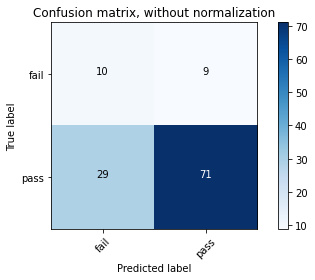

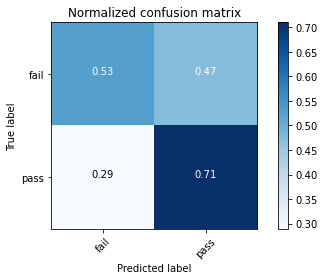

In [46]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

From the above confusion matrix, we can see that the model is quite accurate at prediction passes but not for failures (false positives are high for fail)

## Accuracy

Accuracy in classification problems is the number of correct predictions made by the model over all kinds predictions made.

For a binary classification task it'd look like this:

![accuracy](https://miro.medium.com/max/1064/1*5XuZ_86Rfce3qyLt7XMlhw.png)

__Calculate__ the accuracy of our model:

In [1]:
# calculate

__When to use Accuracy:__

Accuracy is a good measure when the target variable classes in the data are nearly balanced.

Ex:60% classes in our fruits images data are apple and 40% are oranges.

A model which predicts whether a new image is Apple or an Orange, 97% of times correctly is a very good measure in this example.


__When NOT to use Accuracy:__

Accuracy should NEVER be used as a measure when the target variable classes in the data are a majority of one class.

## Precision

Precision is a measure that tells us what proportion of students that we predict as having failed, actually failed. 

The predicted positives (People predicted as fail are TP and FP) and the people actually failed are TP.

![precision](https://miro.medium.com/max/1000/1*KhlD7Js9leo0B0zfsIfAIA.png)

__Example:__ 

In a cancer example with 100 people, only 5 people have cancer. 

Let’s say our model is very bad and predicts every case as Cancer. 

Since we are predicting everyone as having cancer, our denominator(True positives and False Positives) is 100 and the numerator, person having cancer and the model predicting his case as cancer is 5. So in this example, we can say that Precision of such model is 5%.

__Calculate__ the precision of our model:

In [2]:
# calculate

## Recall or Sensitivity

Recall is a measure that tells us what proportion of students that actually failed was diagnosed by the algorithm as having failed. 

The actual positives (students with failures are TP and FN) and the people predicted by the model as having failed are TP. 

(Note: FN is included because the student actually failed even though the model predicted otherwise).

![recall](https://miro.medium.com/max/1000/1*a8hkMGVHg3fl4kDmSIDY_A.png)

__Example:__

In our cancer example with 100 people, 5 people actually have cancer. Let’s say that the model predicts every case as cancer.

So our denominator(True positives and False Negatives) is 5 and the numerator, person having cancer and the model predicting his case as cancer is also 5(Since we predicted 5 cancer cases correctly). 

So in this example, we can say that the Recall of such model is 100%. And Precision of such a model(As we saw above) is 5%

__Calculate the recall/sensitivity of our model:__

In [3]:
#calculate

__When to use Precision and When to use Recall?:__

It is clear that recall gives us information about a classifier’s performance with respect to false negatives (how many did we miss), while precision gives us information about its performance with respect to false positives(how many did we caught).

__Precision__ is about being precise. So even if we managed to capture only one cancer case, and we captured it correctly, then we are 100% precise.

__Recall__ is not so much about capturing cases correctly but more about capturing all cases that have “cancer” with the answer as “cancer”. So if we simply always say every case as “cancer”, we have 100% recall.

So basically if we want to focus more on minimising False Negatives, we would want our Recall to be as close to 100% as possible without precision being too bad and if we want to focus on minimising False positives, then our focus should be to make Precision as close to 100% as possible.

##  Specificity

Specificity is a measure that tells us what proportion of students that did NOT fail, were predicted by the model not failing.

The actual negatives (students actually NOT failing are FP and TN) and the people predicted not failing are TN. (Note: FP is included because the student did NOT actually failed even though the model predicted otherwise).

__Specificity is the exact opposite of Recall.__ 

![specificity](https://miro.medium.com/max/848/1*deegiX75imQsVXYVpG_SDQ.png)

Ex: In our cancer example with 100 people, 5 people actually have cancer. Let’s say that the model predicts every case as cancer.

So our denominator(False positives and True Negatives) is 95 and the numerator, person not having cancer and the model predicting his case as no cancer is 0 (Since we predicted every case as cancer). So in this example, we can that that Specificity of such model is 0%.

__Calculate__ the specificity of our model:

In [4]:
#calculate

# F1 Score

Rather than looking a Precision & Recall separately, it’s best if we can get a single score that kind of represents both Precision(P) and Recall(R).

One way to do that is simply taking their arithmetic mean. (P + R) / 2 where P is Precision and R is Recall. But it doesn't work for all situations.

__Example:__

Suppose we have 100 credit card transactions, of which 97 are legit and 3 are fraud and let’s say we came up a model that predicts everything as fraud. 

![fraud](https://miro.medium.com/max/1000/1*YjBz5UyU04AqDtS-EagBVw.png)

If we take arithmetic mean of both, then it comes out to be ~51%. We can't give such a moderate score to a bad model since it’s just predicting every transaction as fraud.

So, we need something more balanced than the arithmetic mean and that is harmonic mean.

`(2xy) / (x+y)`

Harmonic mean is kind of an average when x and y are equal. But when x and y are different, then it’s closer to the smaller number as compared to the larger number.

`F1 Score 
= Harmonic Mean(Precision, Recall)
= 2 * Precision * Recall / (Precision + Recall)
`

For the credit card fraud example:
`
F1 Score = 2 * Precision * Recall / (Precision + Recall) = 2*3*100/103 = 5%
`

So if one number is really small between precision and recall, the F1 Score kind of raises a flag and is more closer to the smaller number than the bigger one, giving the model an appropriate score rather than just an arithmetic mean.

__Calculate the F1 Score of our model:__

In [5]:
# Calculate